In [15]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [16]:
import sys
sys.path.append( '../..' )
from utils import data_preprocesados, plot_mixture

In [3]:
X = data_preprocesados(2, n_components=2, include_categorical=False)
X = pd.DataFrame(X)

[0.35839694 0.2125936 ] 0.5709905462563226


In [4]:
# Definición y entrenamiento del modelo GMM
# ==============================================================================
modelo_gmm = GaussianMixture(
                n_components    = 6,
                covariance_type = 'full',
                random_state    = 123
             )

modelo_gmm.fit(X)

GaussianMixture(n_components=6, random_state=123)

## ¿Cómo saber el número de componentes y tipo de matriz de covarianza?

Al tratarse de un problema no supervisado, no hay forma de conocer de antemano el número de componentes y tipo de matriz de covarianza óptimos. Afortunadamente, al ser un modelo probabilístico, se puede recurrir a métricas como el Akaike information criterion (AIC) o Bayesian information criterion (BIC) para identificar cómo de bien se ajustan los datos observados al modelo creado, a la vez que se controla el exceso de overfitting. En la implementación de Scikit Learn, para ambas métricas, cuanto más bajo el valor, mejor.


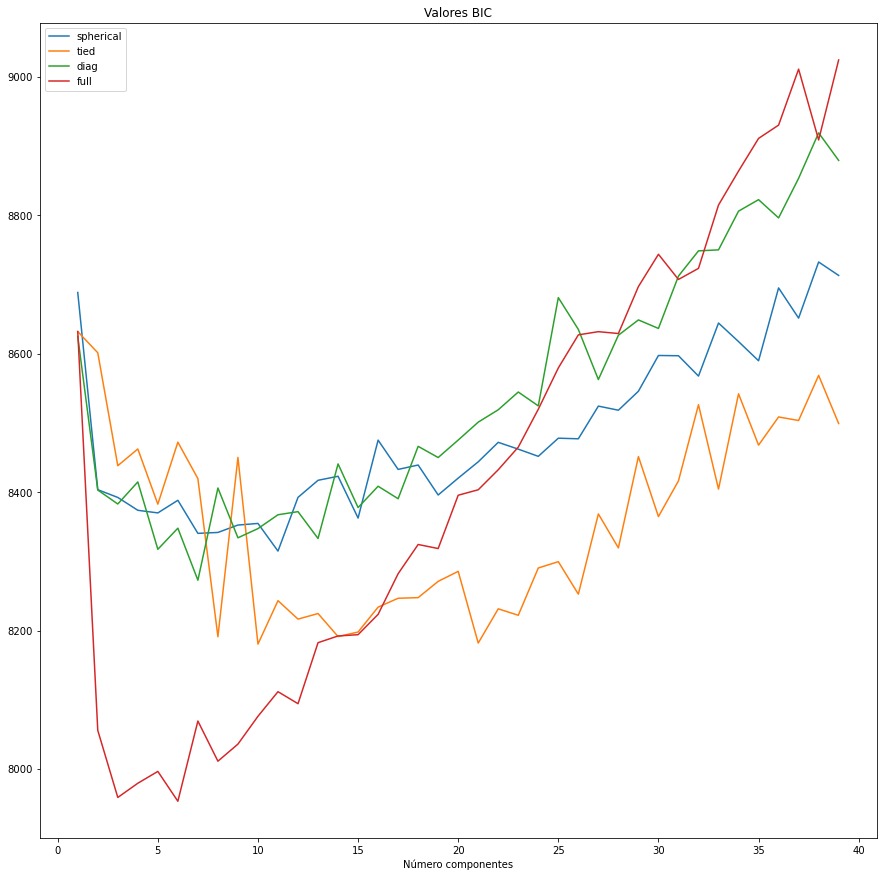

In [5]:
# Tunning del modelo GMM
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 15))

n_components = range(1, 40)
covariance_types = ['spherical', 'tied', 'diag', 'full']

for covariance_type in covariance_types:
    valores_bic = []
    
    for i in n_components:
        modelo = GaussianMixture(n_components=i, covariance_type=covariance_type)
        modelo = modelo.fit(X)
        valores_bic.append(modelo.bic(X))
        
    ax.plot(n_components, valores_bic, label=covariance_type)
        
ax.set_title("Valores BIC")
ax.set_xlabel("Número componentes")
ax.legend();

En base a los valores de BIC, la configuración óptima del modelo es de 5 componentes y matriz de covarianza tipo full. Se entrena de nuevo el modelo utilizando estos valores.

In [6]:
# Entrenamiento del modelo GMM
# ==============================================================================
modelo_gmm = GaussianMixture(
                n_components    = 3,
                covariance_type = 'full',
                random_state    = 123, 
             )

modelo_gmm.fit(X)

GaussianMixture(n_components=3, random_state=123)

# Predicción

Los modelos GaussianMixture tienen varios métodos de predicción. Para utilizarlos como detectores de anomalía, interesa conocer la densidad de probabilidad que tiene cada observación acorde al modelo. Este valor puede obtenerse con el método score_samples(). En la documentación de indica que este método devuelve el logaritmo de la probabilidad, pero, estrictamente hablando, se trata del logaritmo de la densidad de probabilidad. Es por esta razón por la que, si se revierte el logaritmo con la función exponente, se obtienen valores mayores de 1.

In [7]:
# Predicción log probabilidad
# ==============================================================================
log_probabilidad_predicha = modelo_gmm.score_samples(X)
log_probabilidad_predicha

array([-2.96902987, -3.21905797, -3.28427435, ..., -3.00286161,
       -5.02798991, -4.98359215])

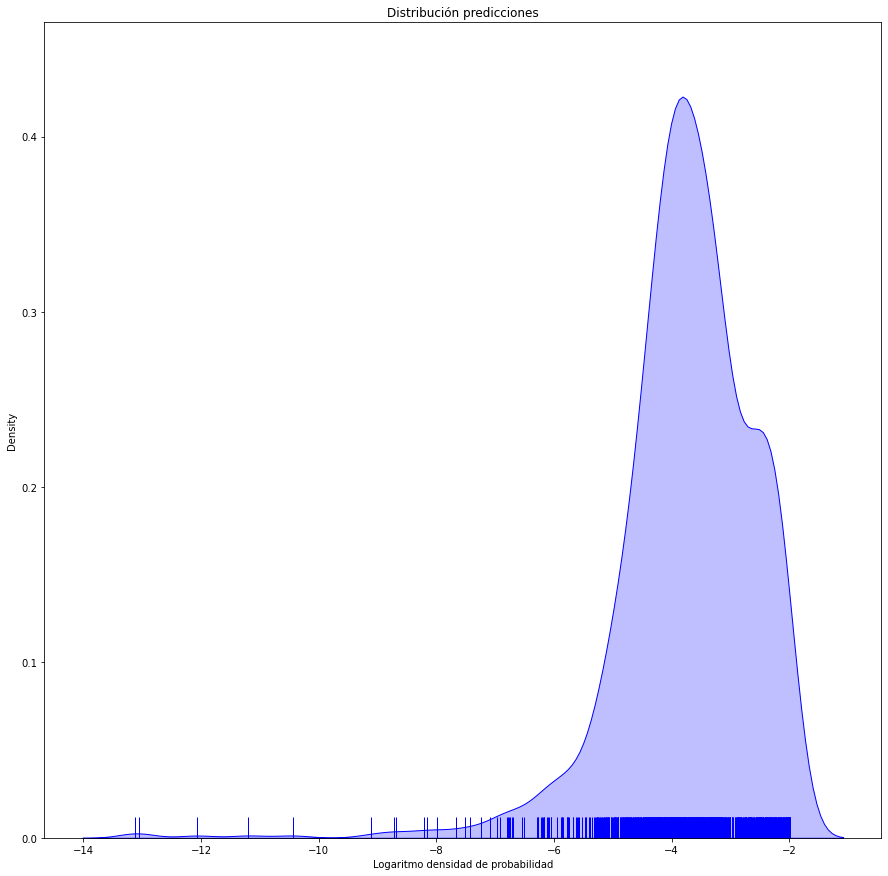

In [8]:
# Distribución de las probabilidades (log density)
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
sns.distplot(
    log_probabilidad_predicha,
    hist    = False,
    rug     = True,
    color   = 'blue',
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = ax
)

ax.set_title('Distribución predicciones')
ax.set_xlabel('Logaritmo densidad de probabilidad');

## Detección de anomalías

Una vez calculada la densidad de probabilidad de cada observación acorde al modelo, se pueden emplear como criterio para identificar anomalías. Cabría esperar que, observaciones con una probabilidad predicha muy baja, sean anómalas.
En la práctica, si se está empleando esta estrategia de detección es porque no se dispone de datos etiquetados, es decir, no se conoce qué observaciones son realmente anomalías.

In [9]:
# Distribución de los valores de anomalía
# ==============================================================================
df_resultados = pd.DataFrame({
                    'log_probabilidad' : log_probabilidad_predicha,
                    'anomalia' : datos_y
                })

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 3.5))
sns.boxplot(
    x     = 'anomalia',
    y     = 'log_probabilidad',
    data  = df_resultados,
    #color = "white",
    palette = 'tab10',
    ax    = ax
)

ax.set_title('Distribución predicciones GMM')
ax.set_ylabel('Logaritmo densidad de probabilidad')
ax.set_xlabel('clasificación (0 = normal, 1 = anomalía)');

NameError: name 'datos_y' is not defined

## Reentrenamiento iterativo

El modelo anterior se ha entrenado empleando todas las observaciones, incluyendo potenciales anomalías. Dado que el objetivo es aprender las distribuciones de las componentes únicamente con los datos “normales”, se puede mejorar el resultado reentrenando el modelo pero excluyendo las n observaciones con menor probabilidad (potenciales anomalías).

Se repite la detección de anomalías pero, esta vez, descartando las observaciones con una densidad de probabilidad inferior al cuantil 0.01. 

In [10]:
# Se eliminan las observaciones con una densidad de probabilidad inferior
# al cuantil 0.01
# ==============================================================================
cuantil = np.quantile(a=log_probabilidad_predicha,  q=0.01)
print('Cuantil: ', cuantil)
datos_X_trimmed = X.loc[log_probabilidad_predicha > cuantil, :].copy()
#datos_y_trimmed = datos_y[log_probabilidad_predicha > cuantil].copy()

Cuantil:  -7.847975287215086


In [11]:
datos_X_trimmed

,0,1
0,-1.182702,-0.894509
1,-2.378028,-0.920366
2,-1.180880,0.228295
3,-2.800700,-0.239995
4,-1.542936,-1.219243
...,...,...
1039,2.249415,0.303846
1040,3.383209,-3.571794
1041,-2.564589,-0.776066
1042,2.635586,3.352860


In [12]:
# Entrenamiento del modelo GMM
# ==============================================================================
modelo_gmm = GaussianMixture(
                n_components    = 3,
                covariance_type = 'full',
                random_state    = 123, 
             )

modelo_gmm.fit(X=datos_X_trimmed)

GaussianMixture(n_components=3, random_state=123)

In [13]:
# Matriz de confusión de la clasificación final
# ==============================================================================
df_resultados = pd.DataFrame({
                    'log_probabilidad': modelo_gmm.score_samples(X),
                    'anomalia' : datos_y
                })

df_resultados = df_resultados \
                .sort_values('log_probabilidad', ascending=True) \
                .reset_index(drop=True)

df_resultados['clasificacion'] = np.where(df_resultados.index <= 176, 1, 0)

pd.crosstab(
    df_resultados.anomalia,
    df_resultados.clasificacion
)

NameError: name 'datos_y' is not defined